In [1]:
#!/usr/bin/env python
import sys,os
#print sys.path
sys.path=["/home/zhi/SULI21","/home/zhi/april/py"]+sys.path
print(sys.path)
from Parameter import Parameter
from BaseLikelihood import BaseLikelihood
import MCMCAnalyzer
import numpy as np
import quasim as qua
import math
import matplotlib.pyplot as plt
import corner
from uncertainties import ufloat
from uncertainties.umath import sqrt

['/home/zhi/SULI21', '/home/zhi/april/py', '/home/zhi/SULI21/notebook', '/usr/lib/python39.zip', '/usr/lib/python3.9', '/usr/lib/python3.9/lib-dynload', '', '/home/zhi/.local/lib/python3.9/site-packages', '/usr/local/lib/python3.9/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3.9/dist-packages', '/home/zhi/.local/lib/python3.9/site-packages/IPython/extensions', '/home/zhi/.ipython']


In [3]:
# Create Input data
QT = qua.QuaTel(DL=np.pi)
BSC = qua.BSC_process("/home/zhi/SULI21/bsc5.dat")

lam = 1*10**(-6)
#NEW YORK COORD but the overall baseline is E-W, with B ~ 190m
pos_t_NY = [[-1.3,0.71,6.4*10**(6)],[-1.30004,0.71,6.4*10**(6)]]   #Baseline vector in [RA,DEC,RADIUS]
pos = BSC.BSC_filter(pos_t_NY,3)
# Use some sample star, here I use sample pos[0] as a sample star
print('pos16',pos[16])
T = 20000   

num, t, baseline, theo_phase, d_source = QT.get_num_photon(pos[16],pos_t_NY,lam,T,'pos')
num = num[0] 
theo_phase = theo_phase[0]

#create simulated data based on theoretical rates generated above
task4 = qua.sim_data(num*1,t,theo_phase,'pos')   
print('theo_d',d_source[0,0,:])
print(QT.ph)

pos16 [[5.06200000e+03 3.51345687e+00 9.59722619e-01 9.05944064e+01]
 [5.05400000e+03 3.50778455e+00 9.58626940e-01 4.49884866e+02]]
theo_d [ 0.00201149 -0.00271418  0.00062913]
-2.1765595179585695


In [5]:
# Finds theoretical separation and separation by direct subtraction

def theo_ds(pos, theo):  #pos in [#,phi,dec,s] find midpoint theta and phi.
    
    pos[:,2] = np.pi/2. - pos[:,2]
    print('theo_pos',pos)
    x = np.sin(pos[:,2])*np.cos(pos[:,1])
    y = np.sin(pos[:,2])*np.sin(pos[:,1])
    z = np.cos(pos[:,2])
    #print(x,y,z)
    r = np.linalg.norm(np.array([x[0]+x[1],y[0]+y[1],z[0]+z[1]])/2)
    s = np.linalg.norm(np.array([x[0]+x[1],y[0]+y[1]])/2)
    phi = math.atan2((x[0]+x[1]),(y[0]+y[1]))
    #d_ew = (s/r)*(pos[0,1]-pos[1,1])  # using midpoint
    #d_ew = np.sin(pos[0,2])*pos[0,1]-np.sin(pos[0,2])*pos[1,1]   #actual
    d_ra = (pos[0,1]-pos[1,1])     #+ 3.375e-9
    d_dec = (pos[0,2] - pos[1,2])  #- 2.89902e-9
    
    # Use theo d_source in cart to convert to d_ns and d_ew
    d_dec_theo = -theo[2]*r/s
    
    new_x = (((z[0]+z[1])/2)/r)*d_dec_theo
    
    d_ew_x = (theo[0]+np.cos(np.pi/2 + phi)*new_x)/(np.sin(-(np.pi/2 + phi)))
    
    d_ew_y = (-theo[1]-np.sin(-(np.pi/2 + phi))*new_x)/(np.cos(np.pi/2 + phi))
    
    d_ra_theo = d_ew_x*r/s    
    
    print('diff in RA', d_ra - d_ra_theo)
    print('diff in DEC', d_dec - d_dec_theo)
    
    return d_dec, d_ra, d_dec_theo, d_ra_theo


d_dec, d_ra, d_dec_theo, d_ra_theo = theo_ds(pos[16],d_source[0,0,:])

#theoretical par value which can be used as initial guess if needed.
theo_par = [task4.V,d_ra_theo,d_dec_theo,QT.ph]

print('theo_par',theo_par)


theo_pos [[5.06200000e+03 3.51345687e+00 6.11073708e-01 9.05944064e+01]
 [5.05400000e+03 3.50778455e+00 6.12169387e-01 4.49884866e+02]]
diff in RA -3.3750634830312376e-09
diff in DEC 2.899018798673339e-09
theo_par [0.27904527740988017, 0.005672323444045145, -0.0010956818183263065, -2.1765595179585695]


In [21]:
# create sim_data class for mcmc

class sim_data(BaseLikelihood):
    
    def __init__(self, seed, pos_t, pos_s, t, lam):  # seed = [V_init,d_ra_init, d_dec_init]
        BaseLikelihood.__init__(self,"sim_data")  
        
        # free par
        self.seed = seed
        self.V = seed[0]
        self.d_ra = seed[1]
        self.d_dec = seed[2]
        self.offset = seed[3]
        
        # fixed values
        self.t = t             # timestamp for the sim data
        
        pos_t = np.array(pos_t)
        pos_t[:,1] = np.pi/2 - pos_t[:,1]   # baseline vector in spherical baseline [[phi,theta,r],[phi,theta,r]]
        self.pos_t = pos_t     # position of the two telescope in Earth coordinate
        
        pos_s = np.delete(pos_s, 0, axis=1)  # delete star # part.
        pos_s[:,1] = np.pi/2 - pos_s[:,1]
        self.pos_s = pos_s     # position of sources to determine midpoint
        
        self.lam = lam         # lambda for observation
        self.Omega_E = 7.292e-5
        
    def freeParameters(self):
        return [
                Parameter("V", self.seed[0], err=0.01),    #0.05
                Parameter("d_ra",self.seed[1], err=1e-9),   #1e-7
                Parameter("d_dec",self.seed[2], err=1e-9),
                Parameter("offset",self.seed[3], err=np.pi/10)   #pi/10
                ]
    
    def updateParams(self,params):    #params is also a class, updates param value.
        for p in params:
            if p.name=="V":
                self.V=p.value
            if p.name=="d_ra":
                self.d_ra=p.value
            if p.name=="d_dec":
                self.d_dec=p.value
            if p.name=="offset":
                self.offset=p.value
                
    def pos_carte(self, ti):
            # rotate baseline vector as func of time
            
            if (ti == 0.0).all() :   # for pos source
                x = np.sin(self.pos_s[:,1])*np.cos(self.pos_s[:,0])
                y = np.sin(self.pos_s[:,1])*np.sin(self.pos_s[:,0])
                z = np.cos(self.pos_s[:,1])
               
                r = np.linalg.norm(np.array([x[0]+x[1],y[0]+y[1],z[0]+z[1]])/2)
                s = np.linalg.norm(np.array([x[0]+x[1],y[0]+y[1]])/2)
    
                # close to theoretical d_ns and d_ew
                d_ew = s/r * self.d_ra
                d_ns = self.d_dec
                
                
                #converting to Earth coord
                #rotate around d_ew axis, y axis
                fin_z = (s/r)*d_ns
                new_x = (((z[0]+z[1])/2)/r)*d_ns    #multiplied by d_ew and d_ns
                
                # rotate around z axis
                phi = math.atan2((x[0]+x[1]),(y[0]+y[1]))
                fin_x = np.cos(np.pi/2 + phi)*new_x - np.sin(-(np.pi/2 + phi))*d_ew
                fin_y = np.sin(-(np.pi/2 + phi))*new_x + np.cos(np.pi/2 + phi)*d_ew
                
                new_pos = -np.array([fin_x,fin_y,fin_z])    # since theta hat points down

                return new_pos
            
            else:
                N = ti.size 
                M = len(pos)
                
                new_t = np.tile(ti,(2,1))   # (2,N)
            
                pos_tile = np.tile(np.reshape(self.pos_t,(2,1,3)),(1,N,1))    #pos of telescope, 2,N,3
                
                new_pos = np.zeros((2,N,3))
            
                #change from spherical to cartesian
                new_pos[:,:,0] = pos_tile[:,:,2]*np.sin(pos_tile[:,:,1])*np.cos(pos_tile[:,:,0] + self.Omega_E*new_t)   #[x,y,z](t)
                new_pos[:,:,1] = pos_tile[:,:,2]*np.sin(pos_tile[:,:,1])*np.sin(pos_tile[:,:,0] + self.Omega_E*new_t)
                new_pos[:,:,2] = pos_tile[:,:,2]*np.cos(pos_tile[:,:,1])     

                return new_pos
    
    
    def get_phase(self):       #pos:[[[ra,dec,r],[ra,dec,r]],[[],[]]]

        #let ds be differene of source unit vector
        ds_car = self.pos_carte(np.array([0.]))                   #(3)
        #print(ds_car)
        new_pos_t = self.pos_carte(self.t)           #(2,N,3)
        baseline = new_pos_t[1] - new_pos_t[0]      #(3,N)
        #print(baseline)
        dot = baseline[:,0]*ds_car[0] + baseline[:,1]*ds_car[1] + baseline[:,2]*ds_car[2]
        phase = 2*np.pi/self.lam*dot + self.offset   # Total phase with the offset
        
        return phase
    
    
    
    def loglike_wprior(self):
        
        phase = self.get_phase()
        loglike = np.log(1+self.V*np.cos(phase))  #get loglike for diff phase in 2d array[[],[],[]...]
        res = np.sum(loglike, axis=None)
        
        return res
    
    
    


In [17]:
# CREATE CLASS WITH INPUTS

pos = BSC.BSC_filter(pos_t_NY,3)

# generate some seed
par = [0.25, d_ra_theo-0.5e-9, d_dec_theo-0.8e-9, -2.0]

print(pos[16])
#can also use theoretical par value by changing  par to theo_par
L=sim_data(theo_par,pos_t_NY,pos[16],task4.timestamp,lam)  
L.loglike_wprior()

[[5.06200000e+03 3.51345687e+00 9.59722619e-01 9.05944064e+01]
 [5.05400000e+03 3.50778455e+00 9.58626940e-01 4.49884866e+02]]


7.7298024156967955

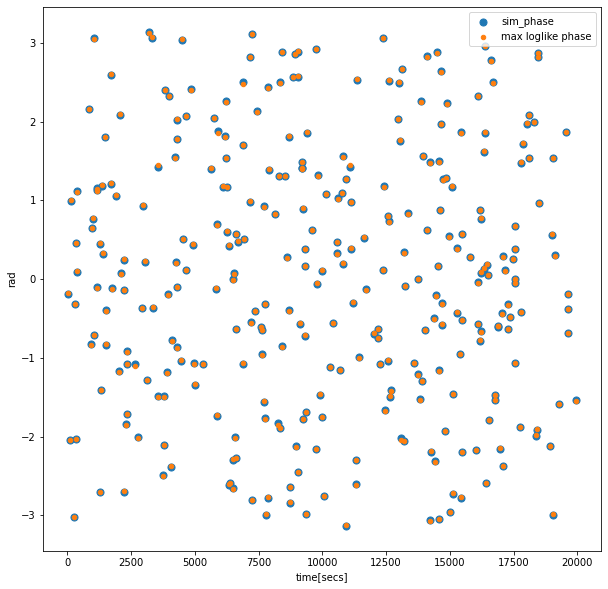

In [18]:
plt.figure(figsize=(10,10))
#plt.subplot(2,2,1)
#plt.plot(t[:200000], np.mod((theo_phase[:200000]+ np.pi),2*np.pi) - np.pi, color = 'g',label='theo phase curve')
plt.scatter(task4.timestamp[-30000:],np.mod((task4.phase[-30000:]+ np.pi),2*np.pi) - np.pi,s=50, label = 'sim_phase')
plt.scatter(task4.timestamp[-30000:], np.mod((L.get_phase()[-30000:]+ np.pi),2*np.pi) - np.pi, s= 20,label = 'max loglike phase')
plt.xlabel('time[secs]');plt.ylabel('rad')
#plt.xlim([14.25,15])
plt.legend()

In [22]:
MCMCAnalyzer.MCMCAnalyzer(L,"/home/zhi/SULI21/MCMC_output/sim_data_1x_ph_1",temp=2, nsamp=300000)

Bounds: [ 2.50000000e-01  5.67182344e-03 -1.09618182e-03 -3.74735584e+00] [ 0.3         0.00567282 -0.00109518 -0.60576319]
Starting chain...
Still burning in, weight too large
60
Still burning in, weight too large
36
Still burning in, weight too large
69
Still burning in, weight too large
44
Still burning in, weight too large
33
Still burning in, weight too large
76
Still burning in, weight too large
32
Still burning in, weight too large
39
Still burning in, weight too large
47
Still burning in, weight too large
45
Still burning in, weight too large
32
Still burning in, weight too large
64
Still burning in, weight too large
38
Still burning in, weight too large
36
Still burning in, weight too large
59
Accepted samples 1000 1
Still burning in, weight too large
58
Still burning in, weight too large
33
Accepted samples 2000 4
Accepted samples 3000 1
Still burning in, weight too large
33
Accepted samples 4000 3
Accepted samples 5000 1
Re-initializing covariance matrix after burn-in
[[ 2.1

Accepted samples 232000 1
Accepted samples 233000 2
Accepted samples 234000 10
Accepted samples 235000 9
Accepted samples 236000 1
Accepted samples 237000 5
Accepted samples 238000 26
Accepted samples 239000 3
Accepted samples 240000 1
Accepted samples 241000 49
Accepted samples 242000 2
Accepted samples 243000 8
Accepted samples 244000 21
Accepted samples 245000 5
Accepted samples 246000 1
Accepted samples 247000 8
Accepted samples 248000 1
Accepted samples 249000 5
Accepted samples 250000 10
Accepted samples 251000 2
Accepted samples 252000 2
Accepted samples 253000 6
Accepted samples 254000 3
Accepted samples 255000 1
Accepted samples 256000 2
Accepted samples 257000 2
Accepted samples 258000 3
Accepted samples 259000 9
Accepted samples 260000 1
Accepted samples 261000 4
Accepted samples 262000 1
Accepted samples 263000 7
Accepted samples 264000 2
Accepted samples 265000 2
Accepted samples 266000 1
Accepted samples 267000 2
Accepted samples 268000 29
Accepted samples 269000 3
Accept

In [13]:
# Comparing between Fisher and MCMC WITHOUT an OFFSET PHASE
res = np.loadtxt("/home/zhi/SULI21/MCMC_output/sim_data_5x_test.txt")
maxRes = np.loadtxt("/home/zhi/SULI21/MCMC_output/sim_data_5x_test.maxlike")

theo_par = np.array([0.2790452774098804, 0.005672323444045146, -0.0010956818183263065,0.0])

mcmc_data = np.delete(np.delete(res, [0,1], axis=1),np.s_[:int(res[:,0].size/2)], axis=0) 
mcmc_data.shape
sigma = np.sqrt(np.cov(mcmc_data,rowvar=False).diagonal())
print("Sigma of parameters:", sigma)

ra = ufloat(maxRes[3], sigma[1])
dec = ufloat(maxRes[4],sigma[2])
exp_d = sqrt(ra**2 + dec**2)
print("Max loglike separation between sources:", exp_d)

k = (1-np.sqrt(1-task4.V**2))/task4.V**2
B = np.linalg.norm(baseline)
theo_d = np.linalg.norm(d_source[0,0,:])
theo_sigma = np.sqrt(6/(k*np.pi**2))/task4.V/np.sqrt(T*task4.avg_rate)*theo_par[2]/task4.N
print("Error of separation between sources by Fisher:", theo_sigma)

Sigma of parameters: [5.22885160e-02 6.48776794e-10 3.76270522e-10]
Max loglike separation between sources: 0.0057771775+/-0.0000000006
Error of separation between sources by Fisher: -1.3267740876379304e-10


In [5]:
# Comparing between Fisher and MCMC WITH an OFFSET PHASE
res = np.loadtxt("/home/zhi/SULI21/MCMC_output/sim_data_5x_ph_1.txt")
maxRes = np.loadtxt("/home/zhi/SULI21/MCMC_output/sim_data_5x_ph_1.maxlike")

theo_par = np.array([0.2790452774098804, 0.005672323444045146, -0.0010956818183263065,0.0])

mcmc_data = np.delete(np.delete(res, [0,1], axis=1),np.s_[:int(res[:,0].size/2)], axis=0) 
mcmc_data.shape
sigma = np.sqrt(np.cov(mcmc_data,rowvar=False).diagonal())
print("Sigma of parameters:", sigma)

ra = ufloat(maxRes[3], sigma[1])
dec = ufloat(maxRes[4],sigma[2])
exp_d = sqrt(ra**2 + dec**2)
print("Max loglike separation between sources:", exp_d)

k = (1-np.sqrt(1-task4.V**2))/task4.V**2
B = np.linalg.norm(baseline)
theo_d = np.linalg.norm(d_source[0,0,:])
theo_sigma = np.sqrt(6/(k*np.pi**2))/task4.V/np.sqrt(T*task4.avg_rate)*theo_par[2]/task4.N
print("Error of separation between sources by Fisher:", theo_sigma)

Sigma of parameters: [5.21292468e-02 9.43142080e-10 7.84040094e-10 8.19029578e-01]
Max loglike separation between sources: 0.0057771760+/-0.0000000009
Error of separation between sources by Fisher: -2.96675705074368e-10


590004
[3.44625539e-02 1.20296251e-09 1.20388681e-09 1.32043358e+00]


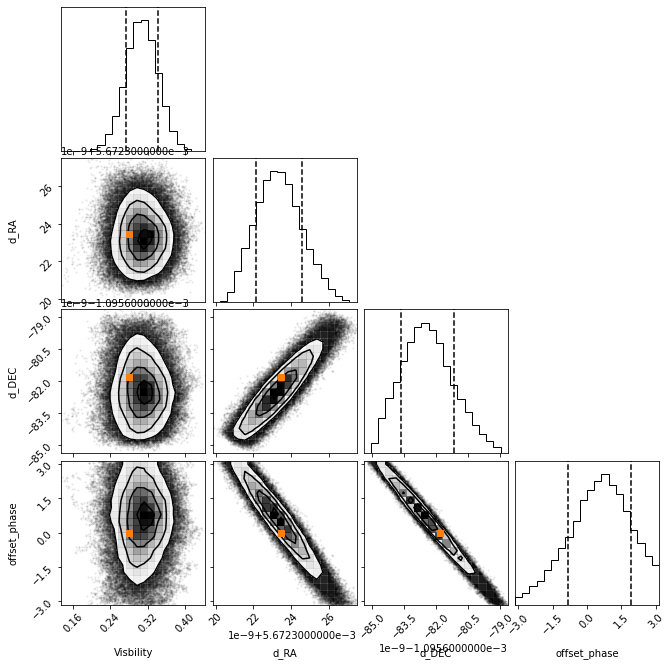

In [14]:
res = np.loadtxt("/home/zhi/SULI21/MCMC_output/sim_data_10x_ph_1.txt")
theo_par = np.array([0.2790452774098804, 0.005672323444045146, -0.0010956818183263065,0.0])

mcmc_data = np.delete(np.delete(res, [0,1], axis=1),np.s_[:int(res[:,0].size/2)], axis=0) 
#mcmc_data = np.delete(res, [0,1], axis=1)

print(mcmc_data.size)
figure = corner.corner(mcmc_data,labels=['Visbility','d_RA','d_DEC','offset_phase'],quantiles=(0.16, 0.84))
corner.overplot_points(figure, theo_par[None], marker="s", color="C1",label="Theo")

sigma = np.sqrt(np.cov(mcmc_data,rowvar=False).diagonal())
print(sigma)

In [17]:
QT.ph

-2.1765595179585695

590004
[5.21292468e-02 9.43142080e-10 7.84040094e-10 8.19029578e-01]


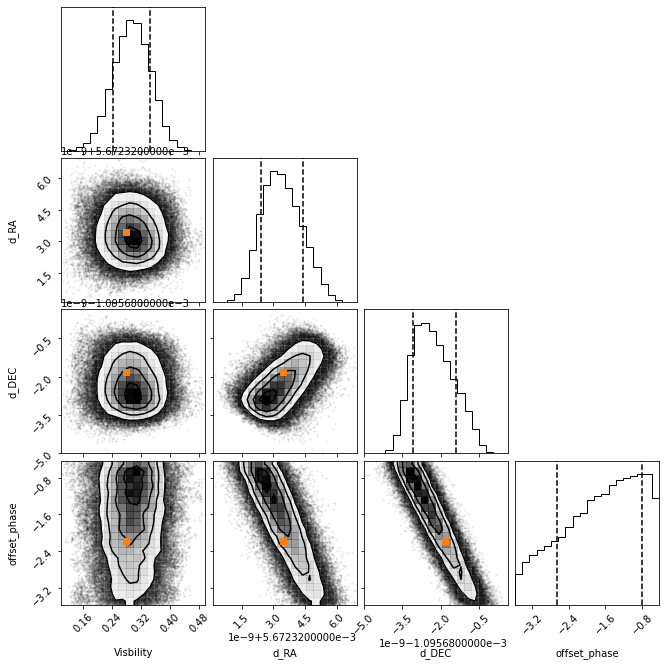

In [8]:
res = np.loadtxt("/home/zhi/SULI21/MCMC_output/sim_data_5x_ph_1.txt")
theo_par = np.array([0.2790452774098804, 0.005672323444045146, -0.0010956818183263065,QT.ph])

mcmc_data = np.delete(np.delete(res, [0,1], axis=1),np.s_[:int(res[:,0].size/2)], axis=0) 
#mcmc_data = np.delete(res, [0,1], axis=1)

print(mcmc_data.size)
figure = corner.corner(mcmc_data,labels=['Visbility','d_RA','d_DEC','offset_phase'],quantiles=(0.16, 0.84))
corner.overplot_points(figure, theo_par[None], marker="s", color="C1",label="Theo")

sigma = np.sqrt(np.cov(mcmc_data,rowvar=False).diagonal())
print(sigma)

590004
[6.66605999e-02 9.66467365e-10 8.29267604e-10 8.31484449e-01]


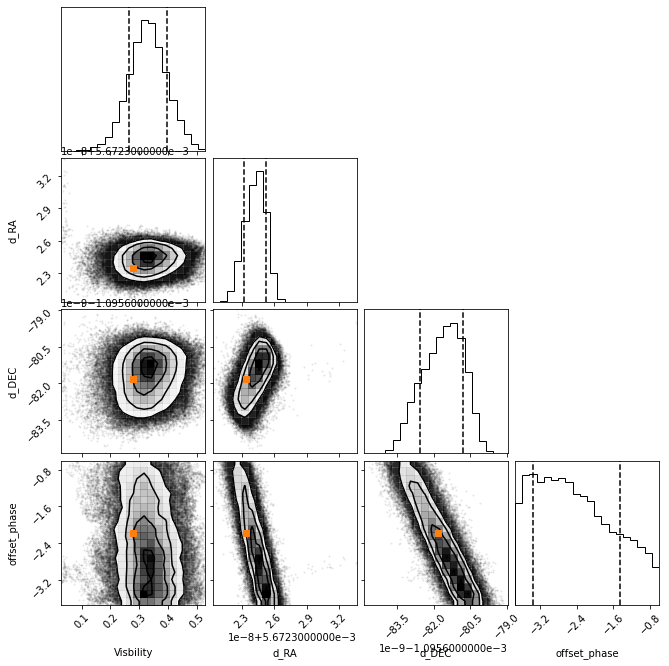

In [10]:
res = np.loadtxt("/home/zhi/SULI21/MCMC_output/sim_data_3x_ph_1.txt")
theo_par = np.array([0.2790452774098804, 0.005672323444045146, -0.0010956818183263065,QT.ph])

mcmc_data = np.delete(np.delete(res, [0,1], axis=1),np.s_[:int(res[:,0].size/2)], axis=0) 
#mcmc_data = np.delete(res, [0,1], axis=1)

print(mcmc_data.size)
figure = corner.corner(mcmc_data,labels=['Visbility','d_RA','d_DEC','offset_phase'],quantiles=(0.16, 0.84))
corner.overplot_points(figure, theo_par[None], marker="s", color="C1",label="Theo")

sigma = np.sqrt(np.cov(mcmc_data,rowvar=False).diagonal())
print(sigma)

590004
[1.31893928e-02 2.79096287e-07 2.76320968e-07 8.73524181e-01]


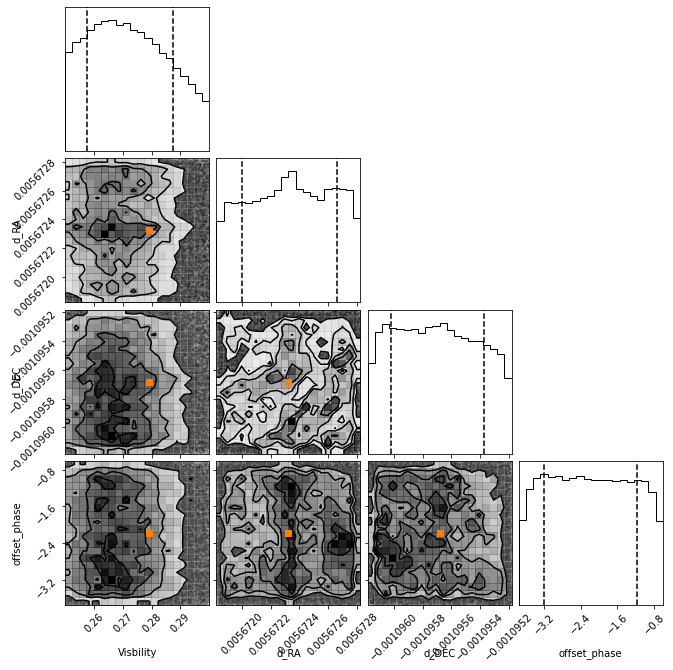

In [4]:
res = np.loadtxt("/home/zhi/SULI21/MCMC_output/sim_data_1x_ph_1.txt")
theo_par = np.array([0.2790452774098804, 0.005672323444045146, -0.0010956818183263065,QT.ph])

mcmc_data = np.delete(np.delete(res, [0,1], axis=1),np.s_[:int(res[:,0].size/2)], axis=0) 
#mcmc_data = np.delete(res, [0,1], axis=1)

print(mcmc_data.size)
figure = corner.corner(mcmc_data,labels=['Visbility','d_RA','d_DEC','offset_phase'],quantiles=(0.16, 0.84))
corner.overplot_points(figure, theo_par[None], marker="s", color="C1",label="Theo")

sigma = np.sqrt(np.cov(mcmc_data,rowvar=False).diagonal())
print(sigma)